# Alumno: Niels Pacheco (a1622)

# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token: 

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen. 

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo**

3. **Probar diferentes técnicas de data augmentation** 

## Desarrollo

In [ ]:
#pip install -r ../requirements.txt

In [ ]:
#pip install -r ../requirements_torch.txt --index-url https://download.pytorch.org/whl/cu121


In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer
import gc

In [119]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  cuda
Torch version:  2.4.1+cu121


In [120]:
# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding



# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


# Transformer Encoder

In [121]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, batch_first: bool, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=batch_first, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
> 
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


## 1. Implementar la arquitectura de un Vision Transformer

In [122]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size: int,
                 patch_size: int,
                 embed_dim: int,
                 num_heads: int,
                 ff_dim: int,
                 num_layers: int,
                 num_classes: int=10,
                 dropout: float=0.1,
                 batch_first=True):
        super(VisionTransformer, self).__init__()

        # Embedding de parches
        self.patch_embedding = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=embed_dim
        )

        # Token [CLS]
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Codificación posicional aprendida
        self.pos_encoding = PositionalEncodingLearned(
            num_patches=self.patch_embedding.num_patches + 1,
            embed_dim=embed_dim
        )

        # Encoder Transformer
        self.transformer_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout,
        )

        # Clasificador final
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Embedding de parches
        x = self.patch_embedding(x)

        # Token [CLS]
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Codificación posicional
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Encoder
        x = self.transformer_encoder(x)

        # Clasificación a partir del token CLS
        cls_output = x[:, 0]
        class_out = self.mlp_head(cls_output)
        
        return class_out


# CIFAR10

In [123]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define transformations for the input data test
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)
class_names = test_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [124]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelos

## 2. Ingresar y ajustar los parametros del modelo

### ViT-Base

In [125]:
'''
A continuacion ingrese los parametros del vit_base

'''

num_epochs = 10

vit_base = VisionTransformer(
    img_size=32,
    patch_size=8,
    embed_dim=64,
    num_heads=4,
    ff_dim=128,
    num_layers=6,
    num_classes=10,
    dropout=0.1,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(vit_base.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_base.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


vit_base = vit_base.to(device)


try:
    vit_base = torch.compile(vit_base)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: 

c:\Proyectos\UBA\VpCIII\venv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Parameter containing:
tensor([[[ 2.6269,  0.6524,  0.3231,  0.3874,  0.6285,  0.5967,  0.4475,
           2.1056, -0.2887,  0.4525, -0.7438,  0.2774,  1.4352,  0.2559,
          -1.5047,  0.5482, -0.5863,  1.2934, -2.1403,  0.3672, -1.0235,
          -0.7085, -0.7880,  1.4582, -0.1445, -0.3032, -0.2557,  0.0611,
           1.5748, -0.5065,  0.6013, -0.9918,  1.0171, -0.6572,  0.6363,
           0.1152, -0.0974,  1.4416, -0.6190, -0.9076,  0.8230,  0.1384,
          -0.2049, -0.8658,  0.1376,  0.9863, -1.5793, -0.3672,  0.1883,
          -1.1242,  0.6533, -0.5678,  0.2440, -0.6106,  0.3372,  0.0956,
           0.5804, -2.4416,  0.7183, -0.3549,  0.5967, -0.5505,  0.0492,
          -0.9945]]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[[[ 0.0432,  0.0367,  0.0457,  ..., -0.0678, -0.0032, -0.0557],
          [-0.0210, -0.0330, -0.0027,  ...,  0.0629, -0.0634, -0.0536],
          [-0.0522, -0.0231,  0.0281,  ...,  0.0157,  0.0341, -0.0622],
          ...,
       

In [126]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000


torch.cuda.empty_cache()
gc.collect()
print("Número de parámetros: {:.2f} millones".format(count_parameters(vit_base)))

Número de parámetros: 0.21 millones


In [127]:
trainer = Trainer(vit_base, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    
    #scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009] WON'T CONVERT forward C:\Users\caro_\AppData\Local\Temp\ipykernel_29460\645824810.py line 47 
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009] due to: 
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009] Traceback (most recent call last):
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009]   File "c:\Proyectos\UBA\VpCIII\venv\lib\site-packages\torch\_dynamo\convert_frame.py", line 948, in __call__
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009]     result = self._inner_convert(
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009]   File "c:\Proyectos\UBA\VpCIII\venv\lib\site-packages\torch\_dynamo\convert_frame.py", line 472, in __call__
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009]     return _compile(
W0523 22:47:44.048000 28388 torch\_dynamo\convert_frame.py:1009]   File "c:\Proyectos\UBA\VpCI

In [128]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(vit_base, test_loader)


100%|██████████| 20/20 [00:03<00:00,  5.67it/s]


In [129]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.52
Precision: 0.51
Recall: 0.52
F1 score: 0.51


In [130]:
train_dataset.data[0].shape

(32, 32, 3)

  0%|          | 0/20 [00:00<?, ?it/s]


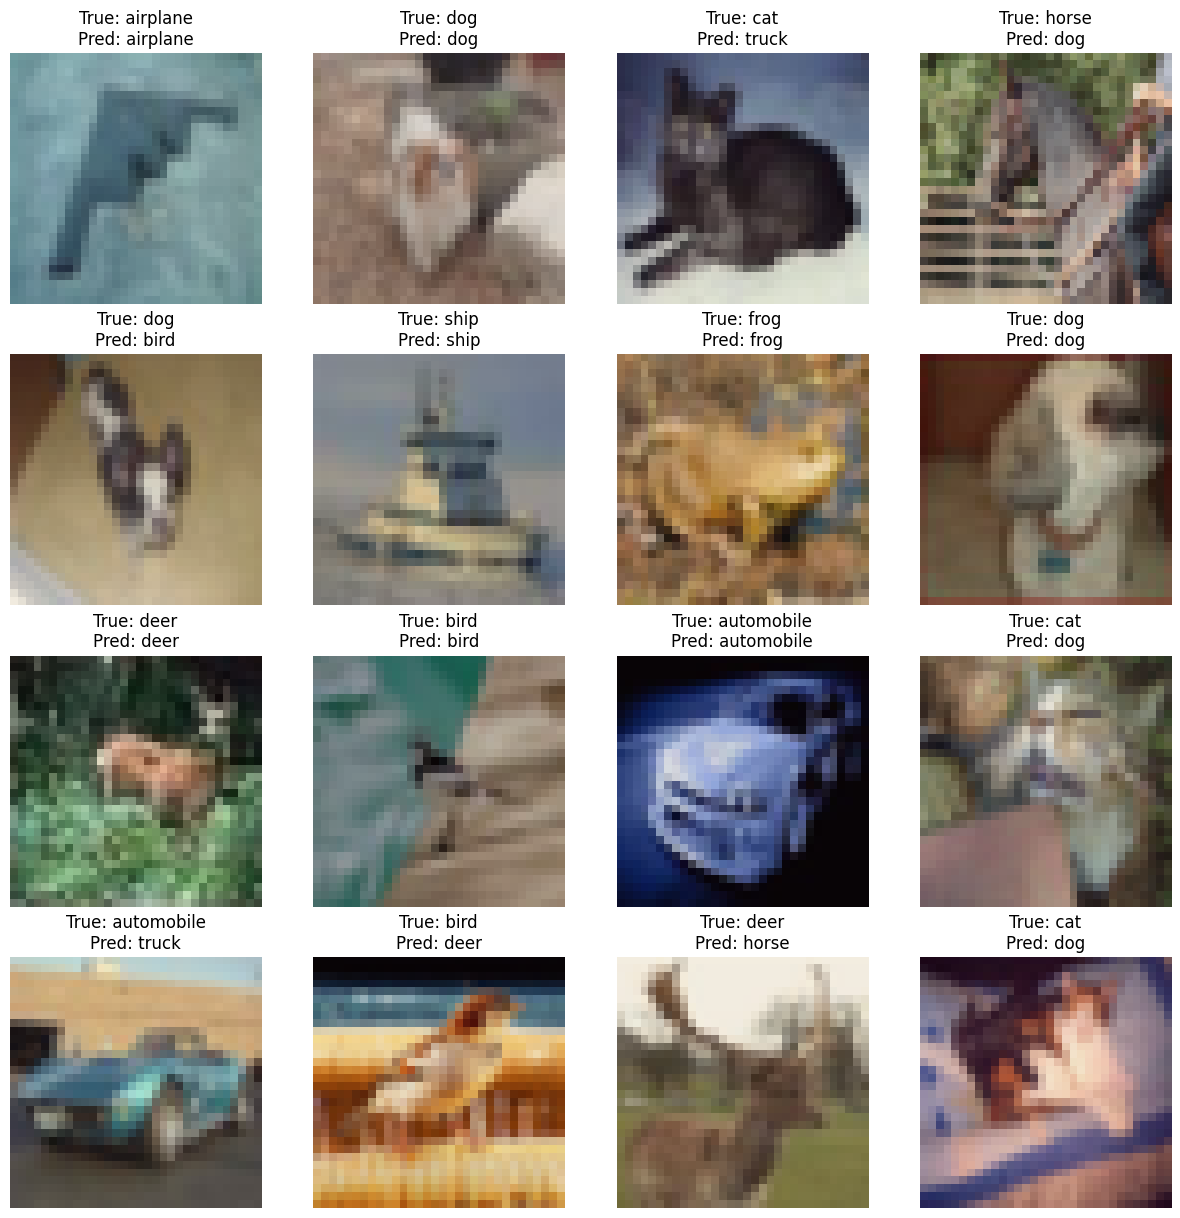

In [131]:

def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(vit_base, test_loader, class_names, num_images=16)
plt.show()


### ViT-Large

In [132]:
'''
A continuacion ingrese los parametros del vit_large

'''

num_epochs = 10

vit_large = VisionTransformer(
    img_size=32,
    patch_size=8,
    embed_dim=128,
    num_heads=8,
    ff_dim=256,
    num_layers=6,
    num_classes=10,
    batch_first=True,
    dropout=0.1,
).to(device)


print("Parametros del modelo:", list(vit_large.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_large.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


vit_large = vit_large.to(device)


try:
    vit_large = torch.compile(vit_large)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


c:\Proyectos\UBA\VpCIII\venv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Parametros del modelo: [Parameter containing:
tensor([[[ 2.4050,  0.9623, -2.1265, -0.2025,  0.5851,  1.9949, -0.3492,
          -0.7271,  0.0540,  0.5348,  1.4016,  1.5965, -0.5844,  1.0564,
           0.7870,  0.4116, -1.5214, -0.2495,  0.1742, -0.4337,  1.0363,
           1.0550, -0.2406, -1.0047, -0.8825,  0.4615,  1.7911,  0.0904,
           0.6234,  0.8351, -1.3141,  0.2108,  0.2673, -0.9675, -0.3116,
          -0.2344,  2.1861, -0.3325, -0.7356, -1.7063,  0.5232, -0.1028,
          -1.2372,  1.4908, -0.9664,  0.8364,  0.3440, -0.2775,  0.4413,
           0.5858, -0.1358,  1.9469, -0.4588,  0.7300, -0.6334, -0.0211,
           1.0501, -0.2525,  0.4557, -0.1340, -0.2353, -0.8851,  0.4756,
           0.3053, -0.2510, -1.9673,  0.1717, -1.5892, -0.5196,  0.0956,
           0.5441, -0.8741,  0.2100,  0.6365, -1.6584, -0.4633,  1.2516,
          -1.3753,  0.8025,  1.6410, -0.3688,  0.9237, -1.0207, -0.3291,
           0.9878, -0.1000,  0.6518, -0.0281,  0.3319, -0.6639,  0.7940,
     

In [133]:
torch.cuda.empty_cache()
gc.collect()
print("Número de parámetros: {:.2f} millones".format(count_parameters(vit_large)))

Número de parámetros: 0.82 millones


In [134]:
trainer_large = Trainer(vit_large, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer_large.train_model(use_amp=True)

loss 1.38271: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]


In [135]:
# Evaluar el modelo
accuracy_l, precision_l, recall_l, f1_l = evaluate_model(vit_large, test_loader)

100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


In [136]:
print(f"Accuracy: {accuracy_l:.2f}")
print(f"Precision: {precision_l:.2f}")
print(f"Recall: {recall_l:.2f}")
print(f"F1 score: {f1_l:.2f}")

Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1 score: 0.56


  0%|          | 0/20 [00:00<?, ?it/s]


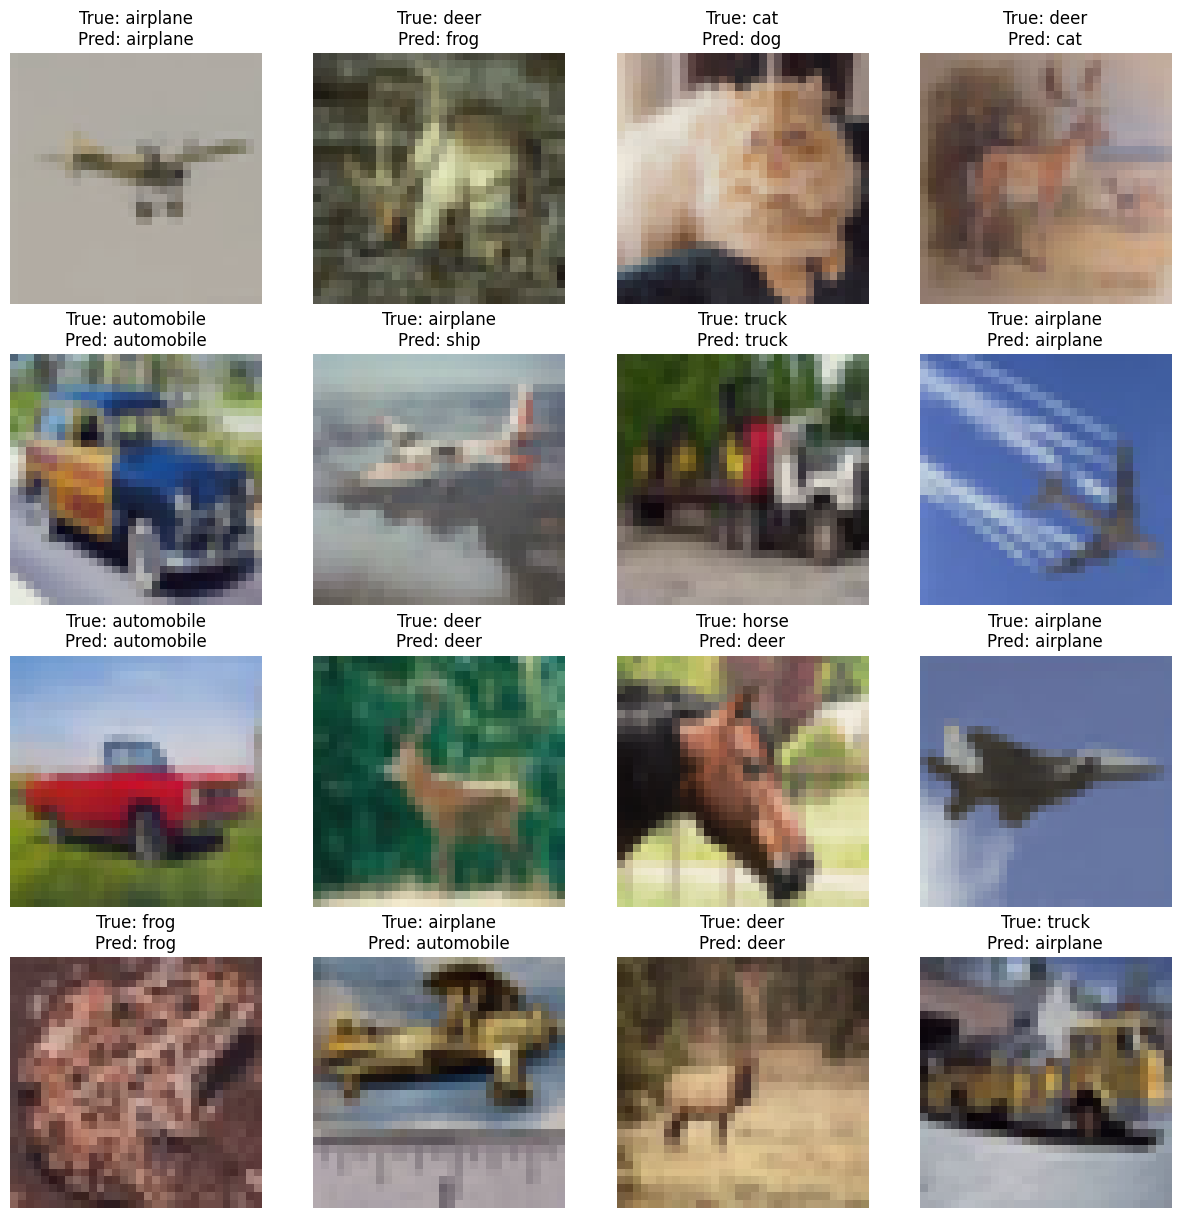

In [137]:
visualize_classification(vit_large, test_loader, class_names, num_images=16)
plt.show()

### Vit_Huge

In [138]:
'''
A continuacion ingrese los parametros del vit_huge

'''

num_epochs = 10

vit_huge = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=256,
    num_heads=8,
    ff_dim=1024,
    num_layers=6,
    num_classes=10,
    batch_first=True,
    dropout=0.1
).to(device)


print("Parametros del modelo:", list(vit_huge.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_huge.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


vit_huge = vit_huge.to(device)


try:
    vit_huge = torch.compile(vit_huge)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


c:\Proyectos\UBA\VpCIII\venv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Parametros del modelo: [Parameter containing:
tensor([[[-1.3815e-01,  1.8506e+00,  5.7226e-01, -3.7141e-01, -1.4059e+00,
           1.4805e+00,  7.3463e-01,  8.8494e-01, -2.1945e-01,  1.7828e-01,
           1.6951e-01, -7.1325e-01, -1.8873e+00, -1.6855e+00, -4.6564e-01,
          -5.6162e-02, -1.7885e+00, -7.8387e-01, -3.0717e-02, -7.7754e-02,
           1.4488e+00,  6.1158e-01,  5.9211e-02, -6.7287e-01, -2.2055e+00,
           3.4328e-01,  1.4751e+00, -2.0660e+00, -1.0350e+00,  4.1451e-01,
          -1.2750e+00, -1.5283e+00,  1.9894e-01, -1.0349e+00,  1.7485e+00,
           8.8325e-01,  5.6475e-01,  1.2928e+00,  2.4909e-02, -4.2306e-01,
           2.0444e-01,  7.6624e-01, -1.4444e-01, -2.6815e+00, -5.1140e-01,
           1.8775e-01, -2.4216e-01, -6.2338e-01, -5.6582e-01,  1.3189e-01,
           5.3490e-02,  9.8891e-01,  1.3363e+00,  1.3763e-01,  7.7669e-01,
          -1.7109e+00,  1.0468e+00, -2.1582e+00, -4.8754e-01, -6.9106e-01,
          -3.7473e-02,  4.5825e-01, -6.0636e-01, -2.37

In [139]:
torch.cuda.empty_cache()
gc.collect()
print("Número de parámetros: {:.2f} millones".format(count_parameters(vit_huge)))

Número de parámetros: 4.75 millones


In [140]:
trainer_huge = Trainer(vit_huge, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer_huge.train_model(use_amp=True)

loss 1.15669: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


In [141]:
# Evaluar el modelo
accuracy_h, precision_h, recall_h, f1_h = evaluate_model(vit_huge, test_loader)

100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


In [142]:
print(f"Accuracy: {accuracy_h:.2f}")
print(f"Precision: {precision_h:.2f}")
print(f"Recall: {recall_h:.2f}")
print(f"F1 score: {f1_h:.2f}")

Accuracy: 0.63
Precision: 0.63
Recall: 0.63
F1 score: 0.62


  0%|          | 0/20 [00:00<?, ?it/s]


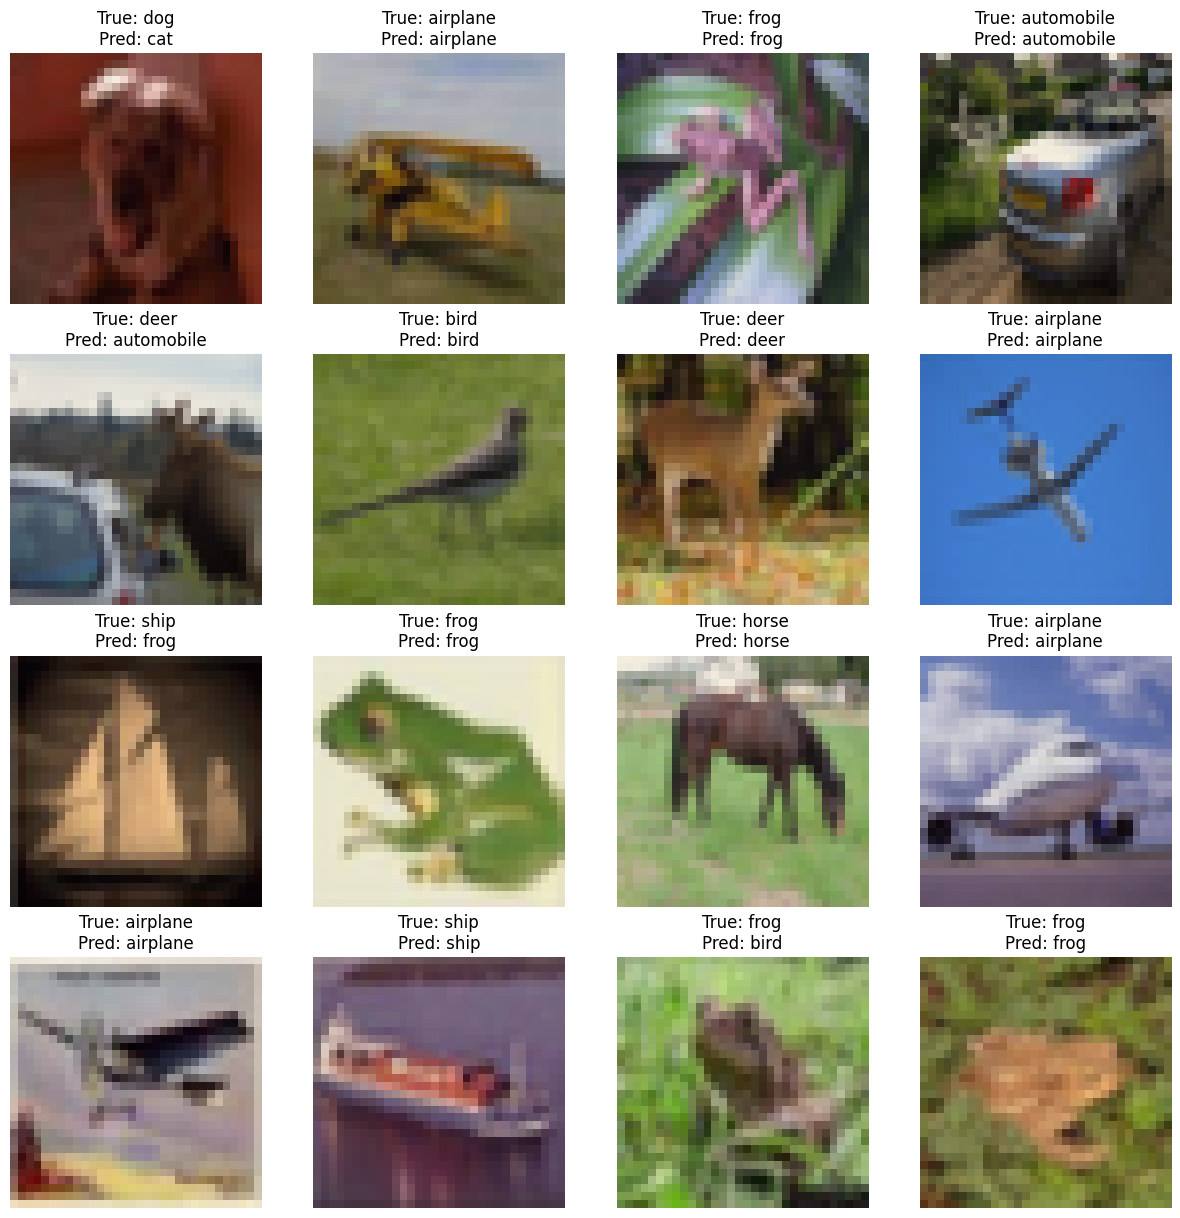

In [143]:
visualize_classification(vit_huge, test_loader, class_names, num_images=16)
plt.show()

3. **Probar diferentes técnicas de data augmentation**

In [144]:
transform_train_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),                      
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(15),                          # Rotación aleatoria ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variación de color
    transforms.ToTensor(),                                  
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Ocultar partes aleatorias
])


In [145]:
train_dataset_2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_2)
train_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)


Files already downloaded and verified


In [146]:
def visualize_inputs(data_loader, num_images=16):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    for inputs, _ in data_loader:
        for j in range(inputs.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images // 4, 4, images_so_far)
            ax.axis('off')
            ax.set_title(f'Imagen {images_so_far}')
            
            # Desnormalizar usando los valores de CIFAR-10
            img = inputs[j].cpu().numpy().transpose((1, 2, 0))
            img = img * [0.2023, 0.1994, 0.2010] + [0.4914, 0.4822, 0.4465]  # Unnormalize
            img = np.clip(img, 0, 1)
            ax.imshow(img)

            if images_so_far == num_images:
                return


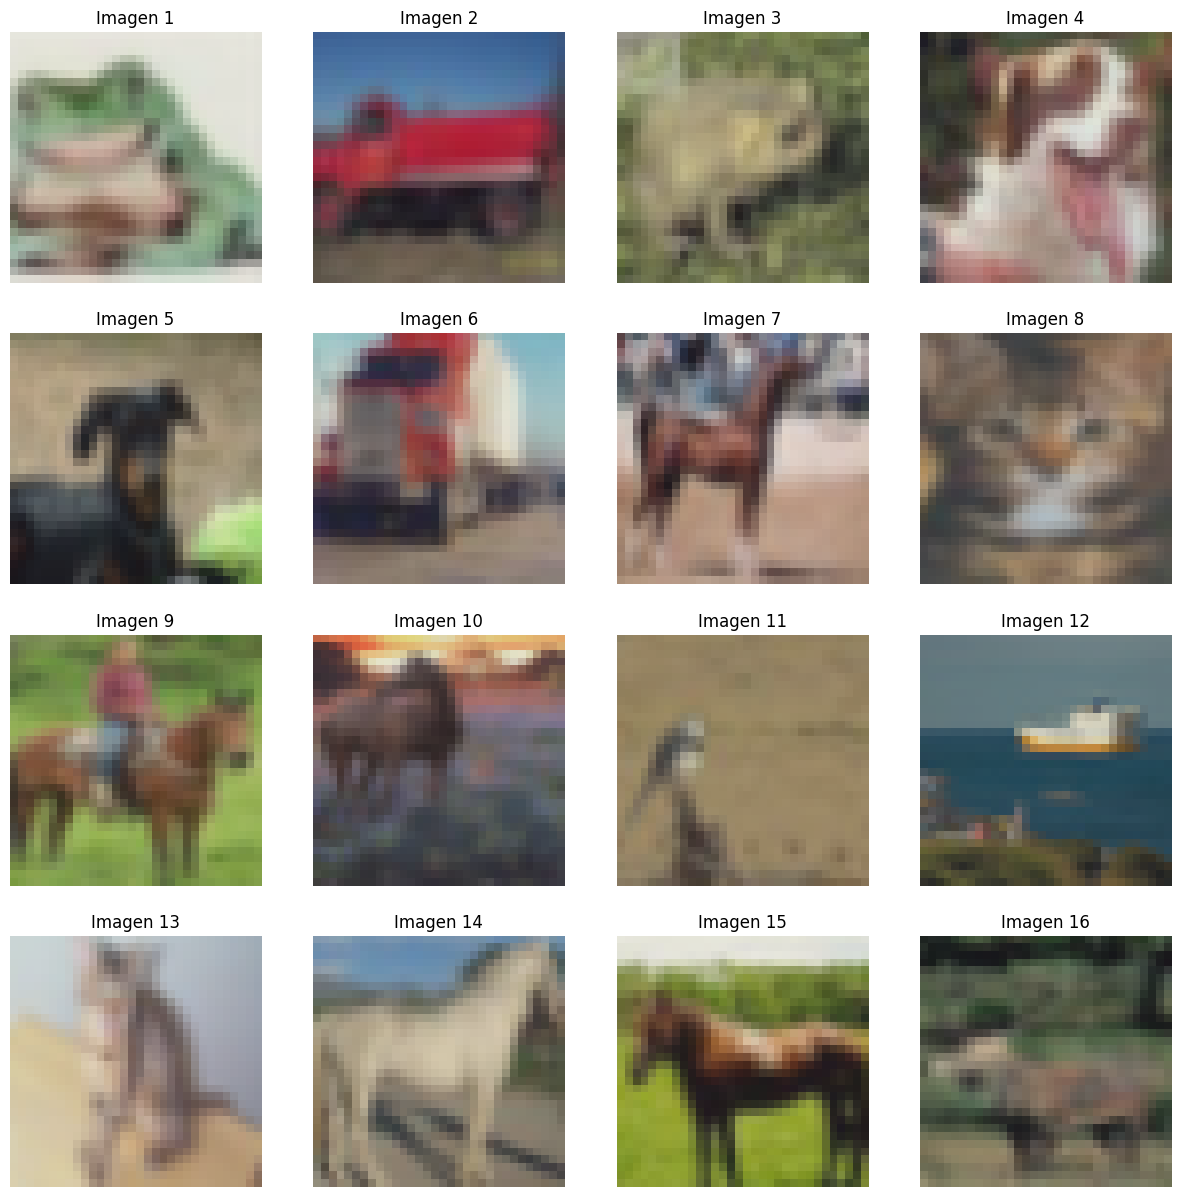

In [147]:
visualize_inputs(train_loader_2, num_images=16)

# Conclusiones
En este trabajo se exploró el uso de diferentes arquitecturas de Vision Transformer (ViT) para clasificar imágenes del conjunto de datos CIFAR-10. Inicialmente se intentó entrenar tres modelos de gran escala: ViT-Base, ViT-Large y ViT-Huge. Sin embargo, estos modelos no lograron aprender de manera adecuada. Una posible explicación es que los valores utilizados (embed_dim altos, muchos parámetros y capas) eran excesivos para un conjunto pequeño y con imágenes de baja resolución como CIFAR-10. Esto llevó a que el modelo no generalice correctamente y tenga dificultades para converger.

### Parámetros de los Modelos Originales (basados en configuraciones estándar de ViT)

| Modelo     | Capas | Embed Dim | Heads | MLP Dim | Params (aprox.) |
|------------|-------|-----------|--------|---------|------------------|
| ViT-Base   | 12    | 768       | 12     | 3072    | 86M              |
| ViT-Large  | 24    | 1024      | 16     | 4096    | 307M             |
| ViT-Huge   | 32    | 1280      | 16     | 5120    | 632M             |

A partir de estos resultados, se redujo la complejidad de las arquitecturas y se diseñaron tres modelos adaptados al tamaño y características de CIFAR-10. Se mantuvo constante la cantidad de capas (6) y se fueron ajustando otros parámetros como embed_dim, num_heads, ff_dim y patch_size. 

### Parámetros de los Modelos Adaptados a CIFAR-10

| Modelo     | Img Size | Patch Size | Embed Dim | Heads | MLP Dim | Capas | Dropout | Params (estimado) |
|------------|----------|------------|-----------|--------|---------|-------|---------|--------------------|
| ViT-Base   | 32       | 8          | 64        | 4      | 128     | 6     | 0.1     | Bajo (~0.2M)         |
| ViT-Large  | 32       | 8          | 128       | 8      | 256     | 6     | 0.1     | Medio (~0.85M)        |
| ViT-Huge   | 32       | 4          | 256       | 8      | 1024    | 6     | 0.1     | Alto (~4.75M)        |

Los resultados obtenidos fueron los siguientes:

ViT-Base reducido: accuracy de 0.51

ViT-Large reducido: accuracy de 0.56

ViT-Huge reducido: accuracy de 0.63

Estos resultados muestran que al aumentar moderadamente la complejidad del modelo, se logra una mejora constante en las métricas de evaluación. Además, se observó que un patch_size más pequeño (4 en lugar de 8) permitió al modelo capturar mejor los detalles en imágenes pequeñas como las de CIFAR-10.

En conclusión, si bien los modelos ViT grandes originales no fueron adecuados para este conjunto de datos, las versiones reducidas permitieron entrenar modelos funcionales que alcanzaron un rendimiento aceptable. Cabe destacar que es muy probable que el rendimiento de estos modelos continúe mejorando si se entrenan durante un mayor número de épocas.